In [2]:
import os
from tqdm import tqdm
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-27 21:11:20.123239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 21:11:20.123310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 21:11:20.205569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 21:11:20.322684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
SEED = 42
PATH = '/home/ychien13/my_github/DAT490/original_datasets'
LABELS = ['meningioma', 'normal', 'pituitary', 'glioma']
COLORS = [
    '#C44E5280',#Red
    '#55A86880',#Green
    '#4C72B080',#Blue
    '#E39C3980',#Orange
]

In [4]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
images=[]
labels=[]
file_path=[]
for type_index,cancer_type in enumerate(LABELS):
    folder_path = f'{PATH}/{cancer_type}'
    for image in tqdm(os.listdir(folder_path)):
        try:
            img_path=os.path.join(folder_path,image)
            img=cv2.imread(img_path)
            img = cv2.resize(img,(250,250))
            file_path.append(img_path)
            images.append(img)
            labels.append(type_index)
        except Exception as e:
            print(f'Error {e}')

file_path=np.array(file_path)
labels = np.array(labels)
images = np.array(images)

 27%|██▋       | 1078/4005 [00:01<00:03, 742.21it/s]

Error OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 42%|████▏     | 1694/4005 [00:02<00:03, 759.22it/s]

Error OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 65%|██████▌   | 2607/4005 [00:03<00:01, 763.02it/s]

Error OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 4178/4178 [00:08<00:00, 510.73it/s]


In [6]:
dataset = pd.DataFrame({
    'file_path': file_path,
    'labels' : labels
})

In [7]:
X_train,X_test,y_train,y_test = train_test_split(images,
                                                 dataset,
                                                 train_size=0.7,
                                                 test_size=0.3,
                                                 stratify=labels,
                                                 shuffle=True,
                                                 random_state=SEED
                                                )

In [8]:
model = load_model('cnn_model.keras')

2025-04-27 21:12:05.171438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2025-04-27 21:12:05.175818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79195 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [9]:
with tf.device('/GPU:0'):
    predict = model.predict(X_test)

2025-04-27 21:12:13.046590: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-27 21:12:15.842398: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-27 21:12:20.021846: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


146/146 [==============================] - 10s 9ms/step


### Misclassification analysis

> Here we start off with using histogram to understand what each tumor type is the misclassified the most into , since the number are quite low we use histogram inside of a pie chart

In [10]:
result = y_test
y_pred = np.argmax(predict,axis=1)
result['prediction'] = np.array(y_pred)

In [11]:
def add_label(pct,dataset):
    total = sum(dataset)
    type_count = (pct/100)*total
    return f'{pct:.0f}' #%\n({type_count:.0f})'
    
def plot_pie(dataset,ax,cancer_type):

    sns.set_style('darkgrid')
    histogram = sns.barplot(x=LABELS,y=dataset['prediction'].value_counts().sort_index(),ax=ax,hue=LABELS,palette=COLORS)

    ax.set_title(f'{cancer_type}')
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.bar_label(ax.containers[1], fontsize=10)
    ax.bar_label(ax.containers[2], fontsize=10)
    ax.bar_label(ax.containers[3], fontsize=10)

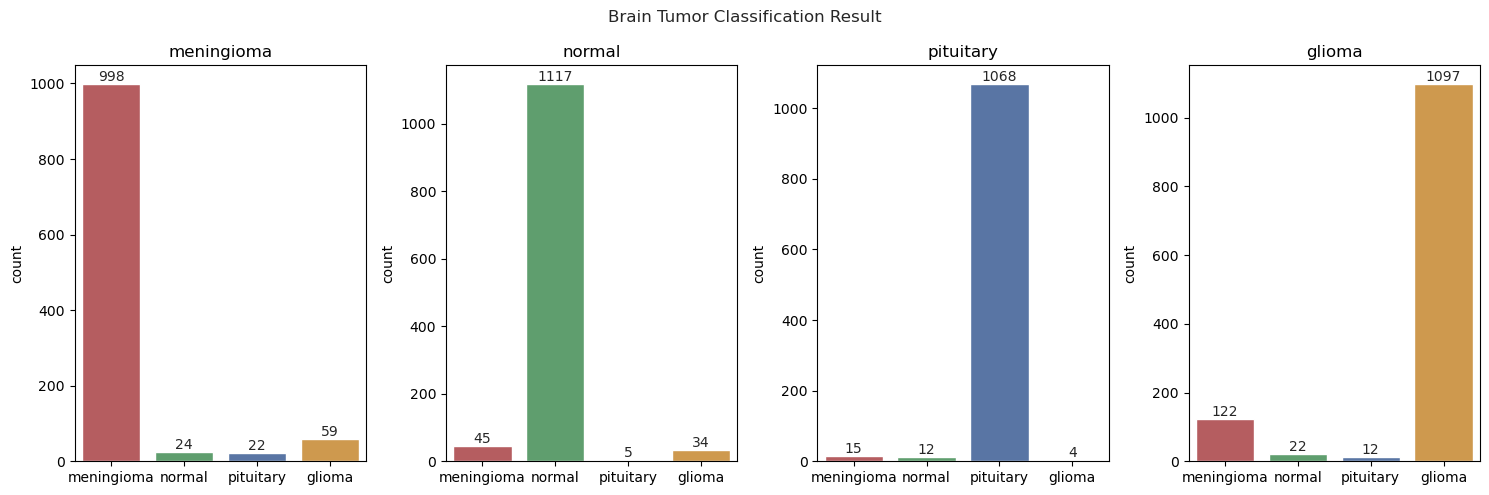

In [12]:
fig, axes = plt.subplots(1,4,figsize=(15,5))

sns.set_style('darkgrid')
for i,ax in enumerate(axes):
    dataset =  result.loc[result['labels']==i]
    plot_pie(dataset,ax,LABELS[i])

fig.suptitle('Brain Tumor Classification Result')
fig.tight_layout()

plt.show()

### Grad-CAM analysis of Convlutional layer
> To further understand each misclassification we randomly pick a misclassified picture to compare it with a picture that is correctly classified to understand what the conlutional layer is picking up on in the misclassified image

In [13]:
def load_image(path):
    images=[]
    img=cv2.imread(path)
    img = cv2.resize(img,(250,250))
    images.append(img)
    images = np.array(images)
    return images

In [14]:
def compute_heatmap(model,layer_name, img:np.array, type_index):

    activation_model = Model(inputs=model.input,
                             outputs=[model.get_layer(layer_name).output,model.output])

    # Watch gradient as model feed foward
    with tf.GradientTape() as tape:
        feature_map, y_pred = activation_model(img)
        score = y_pred[:,type_index]  
    grads = tape.gradient(score,feature_map)
    mean_grads = tf.reduce_mean(grads, axis=(0,1,2))
    
    # Multiply kernel to it's importance and reduce to (1, H, W)
    heatmap = tf.reduce_sum(tf.multiply(mean_grads,feature_map),axis=-1)
    # heatmap = tf.nn.relu(heatmap)
    # heatmap = heatmap / tf.reduce_max(heatmap)
    heatmap = tf.abs(heatmap)
    return heatmap

In [20]:
misclassfied_df = result.loc[result['labels'] != result['prediction']]
misclassfied_df.tail(5)

,file_path,labels,prediction
12622,/home/ychien13/my_github/DAT490/original_datas...,3,0
1150,/home/ychien13/my_github/DAT490/original_datas...,0,3
15212,/home/ychien13/my_github/DAT490/original_datas...,3,0
7226,/home/ychien13/my_github/DAT490/original_datas...,1,0
13267,/home/ychien13/my_github/DAT490/original_datas...,3,0


In [30]:
misclassfied_df = misclassfied_df.reset_index(drop=True)
misclassfied_df.loc[(misclassfied_df['prediction']==2)] # & (misclassfied_df['labels']==0)]

,file_path,labels,prediction
2,/home/ychien13/my_github/DAT490/original_datas...,3,2
10,/home/ychien13/my_github/DAT490/original_datas...,3,2
34,/home/ychien13/my_github/DAT490/original_datas...,0,2
41,/home/ychien13/my_github/DAT490/original_datas...,0,2
63,/home/ychien13/my_github/DAT490/original_datas...,3,2
77,/home/ychien13/my_github/DAT490/original_datas...,0,2
78,/home/ychien13/my_github/DAT490/original_datas...,0,2
91,/home/ychien13/my_github/DAT490/original_datas...,1,2
98,/home/ychien13/my_github/DAT490/original_datas...,0,2
108,/home/ychien13/my_github/DAT490/original_datas...,0,2


In [16]:
layer_names = ['conv2d','conv2d_1','conv2d_2']

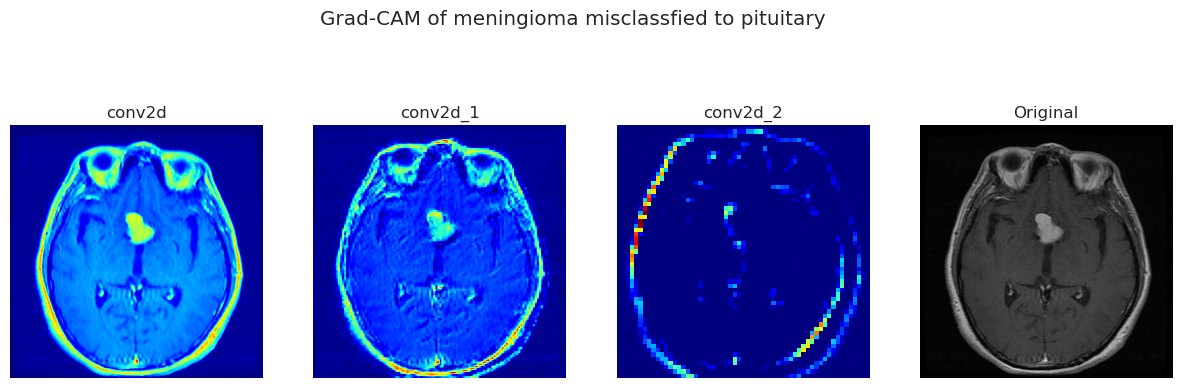

In [38]:
sns.set_theme(style='white')
fig, axes = plt.subplots(1,4,figsize=(15,5))

index=118

img = load_image(misclassfied_df['file_path'].iloc[index])

for col,layer_name in enumerate(layer_names):
    hm = compute_heatmap(model,layer_name,img,0)
    plot1=axes[col].imshow(hm[0],cmap='jet')
    axes[col].set_title(layer_name)
    axes[col].axis('off')

plot2=axes[3].imshow(img[0])
axes[3].set_title('Original')
axes[3].axis('off')

true = misclassfied_df['labels'].iloc[index]
y_pred = misclassfied_df['prediction'].iloc[index]
fig.suptitle(f"Grad-CAM of {LABELS[true]} misclassfied to {LABELS[y_pred]}")
plt.show()

In [ ]:
with tf.device('/GPU:1'):
    vgg_predict = vgg_model.predict(X_test)

In [ ]:
result = y_test
y_pred = np.argmax(vgg_predict,axis=1)
result['vgg_prediction'] = np.array(y_pred)

In [ ]:
misclassfied_df = result.loc[result['labels'] != result['vgg_prediction']]

In [ ]:
# filters = model.layers[0].get_weights()[0]  # Shape: (kernel_height, kernel_width, input_channels, num_filters)
# n_filters = 6

# plt.figure(figsize=(15, 5))

# fig, axes = plt.subplots(4,8, figsize=(20,10))

# for row in range(0,4):
#     for i in tqdm(range(0,8)):
#         f = filters[:, :, :, i]
#         f_min, f_max = f.min(), f.max()
#         f = (f - f_min) / (f_max - f_min)  # normalize to [0,1]
#         sns.heatmap(f[:,:,0],ax=axes[row,i],annot=True,fmt='.1f',cmap='gray')
#         axes[row,i].axis('off')
        
# fig.suptitle("First Conv Layer Filters")
# plt.show()